In [92]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [93]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [94]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [95]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [96]:
tf.keras.backend.clear_session()

In [97]:
subject = 'Espírito Santo - Consumo de Cimento (t)'
start_index = 0
split_index = 191 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 30

In [98]:
data = pd.read_csv('2003_mo_model_input_ES.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Espírito Santo - Desemprego,Espírito Santo - IDH,Espírito Santo - IDH Educacao,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Espírito Santo - Consumo de Cimento (t),Espírito Santo - IDH Longevidade,Espírito Santo - IDH Renda,Espírito Santo- custo m2 (R$),Espírito Santo - PIB - Estadual,Espírito Santo - PIB - Construção Civil,Espírito Santo - PIB - Per Capita,Espírito Santo - PIB - Preços de Mercado,Espírito Santo - Produção de Cimento (t),Espírito Santo - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Espírito Santo - value
0,2003-1,8.177444,0.760059,0.698032,1.637986,1014.886326,1430.287676,24.394984,19.768291,76.995517,2.181755,48.426,0.840524,0.757615,10264.686400,6.342537e+07,3.523987e+06,16.799308,5.948249e+07,98.171240,4.069229e+06,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.268445
1,2003-2,8.171622,0.760222,0.698295,1.638486,1014.889937,1430.121567,24.394230,19.767196,76.994127,2.180648,54.969,0.840977,0.757416,10362.759477,6.350834e+07,3.527412e+06,16.807398,5.951949e+07,97.897317,4.094341e+06,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.270512
2,2003-3,8.165799,0.760385,0.698558,1.638778,1014.892043,1430.024670,24.393791,19.766557,76.993316,2.180003,53.847,0.841429,0.757217,10458.009107,6.359131e+07,3.530838e+06,16.815488,5.955649e+07,98.070539,4.119454e+06,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.271941
3,2003-4,8.159977,0.760548,0.698821,1.638809,1014.892268,1430.014288,24.393743,19.766489,76.993229,2.179934,50.375,0.841882,0.757018,10551.050535,6.367428e+07,3.534263e+06,16.823577,5.959349e+07,98.460789,4.144566e+06,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.273321
4,2003-5,8.154154,0.760710,0.699084,1.655341,1014.807407,1434.131772,24.464335,19.846793,77.041977,2.180096,52.576,0.842335,0.756819,10642.401914,6.375725e+07,3.537689e+06,16.831667,5.963048e+07,99.084134,4.169679e+06,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.274453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36954.021324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36937.748495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36867.947370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36784.826883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


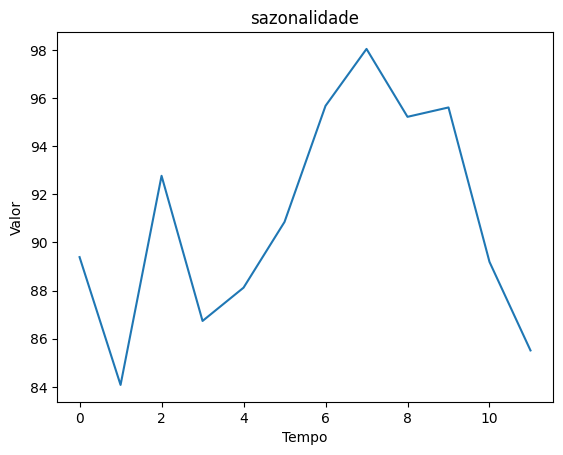

,sazonalidade
sazonalidade,
0,89.389336
1,84.080816
2,92.766791
3,86.737987
4,88.120113
5,90.851233
6,95.673470
7,98.037241
8,95.216830


In [99]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [100]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Espírito Santo - Desemprego,Espírito Santo - IDH,Espírito Santo - IDH Educacao,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Espírito Santo - IDH Longevidade,Espírito Santo - IDH Renda,Espírito Santo- custo m2 (R$),Espírito Santo - PIB - Estadual,Espírito Santo - PIB - Construção Civil,Espírito Santo - PIB - Per Capita,Espírito Santo - PIB - Preços de Mercado,Espírito Santo - Produção de Cimento (t),Espírito Santo - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Espírito Santo - value,sazonalidade,Espírito Santo - Consumo de Cimento (t)
0,2003-1,8.177444,0.760059,0.698032,1.637986,1014.886326,1430.287676,24.394984,19.768291,76.995517,2.181755,0.840524,0.757615,10264.686400,6.342537e+07,3.523987e+06,16.799308,5.948249e+07,98.171240,4.069229e+06,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.268445,89.389336,48.426
1,2003-2,8.171622,0.760222,0.698295,1.638486,1014.889937,1430.121567,24.394230,19.767196,76.994127,2.180648,0.840977,0.757416,10362.759477,6.350834e+07,3.527412e+06,16.807398,5.951949e+07,97.897317,4.094341e+06,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.270512,84.080816,54.969
2,2003-3,8.165799,0.760385,0.698558,1.638778,1014.892043,1430.024670,24.393791,19.766557,76.993316,2.180003,0.841429,0.757217,10458.009107,6.359131e+07,3.530838e+06,16.815488,5.955649e+07,98.070539,4.119454e+06,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.271941,92.766791,53.847
3,2003-4,8.159977,0.760548,0.698821,1.638809,1014.892268,1430.014288,24.393743,19.766489,76.993229,2.179934,0.841882,0.757018,10551.050535,6.367428e+07,3.534263e+06,16.823577,5.959349e+07,98.460789,4.144566e+06,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.273321,86.737987,50.375
4,2003-5,8.154154,0.760710,0.699084,1.655341,1014.807407,1434.131772,24.464335,19.846793,77.041977,2.180096,0.842335,0.756819,10642.401914,6.375725e+07,3.537689e+06,16.831667,5.963048e+07,99.084134,4.169679e+06,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.274453,88.120113,52.576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36954.021324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.120113,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36937.748495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.851233,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36867.947370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.673470,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36784.826883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.037241,NaN


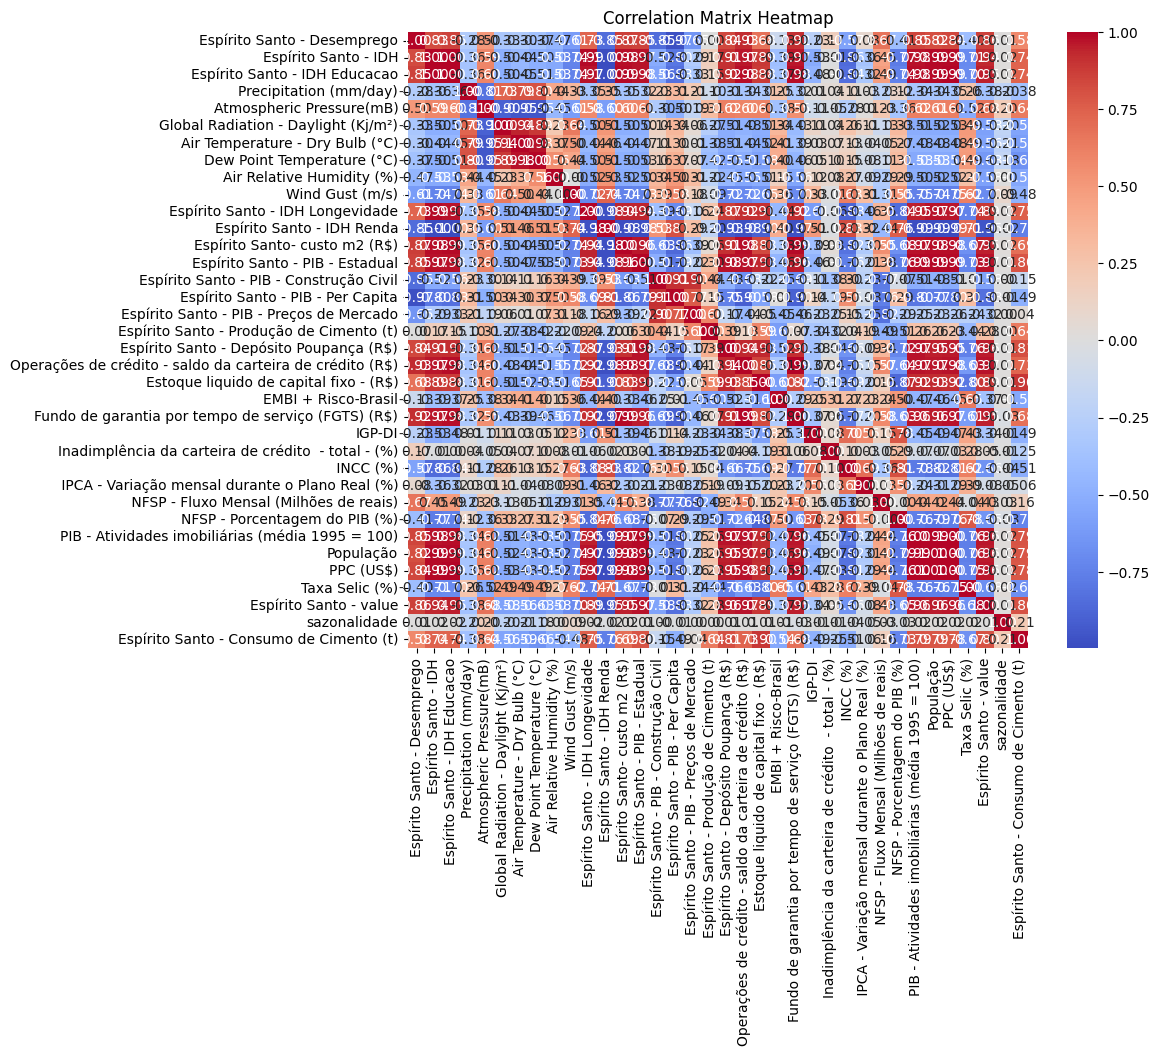

In [101]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [102]:
# data =data.drop(['Air Temperature - Dry Bulb (°C)',
#                  'Precipitation (mm/day)',
#                  'Global Radiation - Daylight (Kj/m²)', 
#                  'Air Relative Humidity (%)'], axis=1)
# data

In [103]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Espírito Santo - Desemprego,Espírito Santo - IDH,Espírito Santo - IDH Educacao,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Espírito Santo - IDH Longevidade,Espírito Santo - IDH Renda,Espírito Santo- custo m2 (R$),Espírito Santo - PIB - Estadual,Espírito Santo - PIB - Construção Civil,Espírito Santo - PIB - Per Capita,Espírito Santo - PIB - Preços de Mercado,Espírito Santo - Produção de Cimento (t),Espírito Santo - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Espírito Santo - value,sazonalidade
0,-0.758586,-2.007957,-1.846427,-0.557551,-0.014840,-0.072166,-0.342027,-0.316813,-0.005104,1.311648,-2.372672,1.910978,-1.573936,-1.927365,-0.943195,0.087180,-1.813287,-1.319688,-1.703471,-1.361787,-2.389042,-0.582420,-1.347324,3.890153,1.258423,3.122582,2.723741,0.364808,4.398348,-1.873379,-2.042341,-1.825286,2.132459,-1.294991,-0.357277
1,-0.763437,-1.978578,-1.824141,-0.556231,-0.013445,-0.073176,-0.342437,-0.317363,-0.005801,1.306375,-2.328193,1.886636,-1.553391,-1.900219,-0.892433,0.126806,-1.716680,-1.326255,-1.687449,-1.361224,-2.352139,-0.799075,-1.380245,3.551840,1.252755,2.970356,2.350880,0.368956,4.222509,-1.868164,-2.014760,-1.813648,1.592202,-1.246951,-1.586646
2,-0.768288,-1.949198,-1.801856,-0.555461,-0.012631,-0.073766,-0.342676,-0.317684,-0.006207,1.303299,-2.283715,1.862294,-1.533438,-1.873074,-0.841670,0.166431,-1.620072,-1.322102,-1.671427,-1.361187,-2.315236,-0.618584,-1.392954,3.391423,1.251338,2.869895,2.123016,0.331110,4.026019,-1.862949,-1.987179,-1.801637,2.999926,-1.213715,0.424889
3,-0.773139,-1.919818,-1.779571,-0.555379,-0.012544,-0.073829,-0.342702,-0.317718,-0.006251,1.302969,-2.239236,1.837952,-1.513947,-1.845928,-0.790908,0.206056,-1.523465,-1.312746,-1.655405,-1.360756,-2.278333,-0.139520,-1.396056,3.135979,1.249134,2.773628,2.021477,0.244570,3.811492,-1.857734,-1.959598,-1.789347,1.273293,-1.181649,-0.971287
4,-0.777990,-1.890438,-1.757285,-0.511712,-0.045329,-0.048781,-0.304325,-0.277397,0.018188,1.303740,-2.194758,1.813610,-1.494810,-1.818783,-0.740145,0.245681,-1.426858,-1.297802,-1.639383,-1.359394,-2.241431,0.494336,-1.388786,2.955412,1.238186,2.977624,1.887113,0.279013,3.567576,-1.851305,-1.932017,-1.777381,2.045407,-1.155335,-0.651209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.925704,1.304933,1.382503,-0.798989,0.865274,-1.705877,-0.891805,-0.627674,0.720000,-1.675993,1.163914,-1.284522,1.712323,1.073521,-0.934891,-1.155565,-0.875236,-1.727603,1.043399,1.316363,0.389193,-0.244459,1.237409,0.589021,-0.685819,-1.749976,-2.010387,2.953658,-0.572934,1.406756,1.365911,1.413217,-1.311366,1.093145,1.645442
188,0.920658,1.292490,1.378338,-0.533704,0.457983,-1.355941,-0.566031,-0.420484,0.345125,-1.306486,1.149434,-1.280575,1.732263,1.056445,-0.903403,-1.167749,-0.908951,-1.753915,1.049376,1.330590,0.370392,-0.199028,1.214214,1.043728,-0.770458,-1.593005,-1.870713,3.351323,-0.588777,1.428132,1.376610,1.425045,-1.417143,1.108075,0.992279
189,0.915611,1.280047,1.374173,-0.593718,0.284180,-0.726814,-0.168555,-0.168242,-0.055131,-0.942080,1.134955,-1.276627,1.754222,1.039370,-0.871915,-1.179933,-0.942665,-1.778143,1.055353,1.352241,0.351592,-0.173807,1.409043,1.387010,-0.910077,-1.351489,-1.806230,3.404908,-0.612606,1.449507,1.387308,1.436067,-1.597784,1.130399,1.082446
190,0.910564,1.267603,1.370009,0.051244,0.026530,-0.184360,0.244201,0.109748,-0.398952,-0

In [104]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-12)
target_data

0      48.646
1      43.597
2      56.331
3      48.488
4      52.856
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Espírito Santo - Consumo de Cimento (t), Length: 249, dtype: float64

In [105]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Espírito Santo - Desemprego,Espírito Santo - IDH,Espírito Santo - IDH Educacao,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Espírito Santo - IDH Longevidade,Espírito Santo - IDH Renda,Espírito Santo- custo m2 (R$),Espírito Santo - PIB - Estadual,Espírito Santo - PIB - Construção Civil,Espírito Santo - PIB - Per Capita,Espírito Santo - PIB - Preços de Mercado,Espírito Santo - Produção de Cimento (t),Espírito Santo - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Espírito Santo - value,sazonalidade
0,-0.758586,-2.007957,-1.846427,-0.557551,-0.014840,-0.072166,-0.342027,-0.316813,-0.005104,1.311648,-2.372672,1.910978,-1.573936,-1.927365,-0.943195,0.087180,-1.813287,-1.319688,-1.703471,-1.361787,-2.389042,-0.582420,-1.347324,3.890153,1.258423,3.122582,2.723741,0.364808,4.398348,-1.873379,-2.042341,-1.825286,2.132459,-1.294991,-0.357277
1,-0.763437,-1.978578,-1.824141,-0.556231,-0.013445,-0.073176,-0.342437,-0.317363,-0.005801,1.306375,-2.328193,1.886636,-1.553391,-1.900219,-0.892433,0.126806,-1.716680,-1.326255,-1.687449,-1.361224,-2.352139,-0.799075,-1.380245,3.551840,1.252755,2.970356,2.350880,0.368956,4.222509,-1.868164,-2.014760,-1.813648,1.592202,-1.246951,-1.586646
2,-0.768288,-1.949198,-1.801856,-0.555461,-0.012631,-0.073766,-0.342676,-0.317684,-0.006207,1.303299,-2.283715,1.862294,-1.533438,-1.873074,-0.841670,0.166431,-1.620072,-1.322102,-1.671427,-1.361187,-2.315236,-0.618584,-1.392954,3.391423,1.251338,2.869895,2.123016,0.331110,4.026019,-1.862949,-1.987179,-1.801637,2.999926,-1.213715,0.424889
3,-0.773139,-1.919818,-1.779571,-0.555379,-0.012544,-0.073829,-0.342702,-0.317718,-0.006251,1.302969,-2.239236,1.837952,-1.513947,-1.845928,-0.790908,0.206056,-1.523465,-1.312746,-1.655405,-1.360756,-2.278333,-0.139520,-1.396056,3.135979,1.249134,2.773628,2.021477,0.244570,3.811492,-1.857734,-1.959598,-1.789347,1.273293,-1.181649,-0.971287
4,-0.777990,-1.890438,-1.757285,-0.511712,-0.045329,-0.048781,-0.304325,-0.277397,0.018188,1.303740,-2.194758,1.813610,-1.494810,-1.818783,-0.740145,0.245681,-1.426858,-1.297802,-1.639383,-1.359394,-2.241431,0.494336,-1.388786,2.955412,1.238186,2.977624,1.887113,0.279013,3.567576,-1.851305,-1.932017,-1.777381,2.045407,-1.155335,-0.651209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,1.538868,1.408727,1.346602,-0.094658,0.078497,0.911266,0.832716,0.238230,-2.008302,-0.345405,1.445510,-1.354699,1.147026,1.007109,-1.505857,-1.639139,-1.626063,-0.138284,0.610245,1.335787,0.819304,0.961603,1.338424,-1.233012,0.749349,-0.883659,-0.214006,1.216560,-0.607704,0.952667,1.031384,1.044043,0.043807,1.037783,-1.586646
158,1.502037,1.408716,1.348982,-0.166709,0.464374,0.086223,0.339955,-0.025443,-1.246005,-1.017572,1.439883,-1.354780,1.167373,1.017654,-1.496536,-1.616758,-1.583348,-0.199466,0.622197,1.325546,0.808136,1.030624,1.300351,-1.299304,0.977327,-0.950771,-0.434717,1.155373,-0.620523,0.954843,1.042716,1.056960,0.210856,1.039895,0.424889
159,1.465205,1.408704,1.351363,-0.481831,0.824659,-0.644945,-0.168876,-0.410117,-0.911422,-1.426643,1.434255,-1.354860,1.187602,1.028199,-1.487214,-1.594377,-1.540633,-0.263743,0.634149,1.315396,0.796969,1.039183,1.250508,-1.248662,1.048267,-1.028465,-0.524091,1.056140,-0.631530,0.957019,1.054049,1.070172,0.107070,1.042387,-0.971287
160,1.428374,1.408692,1.353744,-0.472102,1.186070,-1.031665,-0.628926,-0.789563,-0.790466,-1.529

In [106]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0       48.646
1       43.597
2       56.331
3       48.488
4       52.856
        ...   
157     77.958
158    105.434
159     86.699
160     90.574
161     85.148
Name: Espírito Santo - Consumo de Cimento (t), Length: 162, dtype: float64

In [107]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [108]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(126, 36, 35)

In [109]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Espírito Santo - Desemprego,Espírito Santo - IDH,Espírito Santo - IDH Educacao,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Espírito Santo - IDH Longevidade,Espírito Santo - IDH Renda,Espírito Santo- custo m2 (R$),Espírito Santo - PIB - Estadual,Espírito Santo - PIB - Construção Civil,Espírito Santo - PIB - Per Capita,Espírito Santo - PIB - Preços de Mercado,Espírito Santo - Produção de Cimento (t),Espírito Santo - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Espírito Santo - value,sazonalidade
126,0.929165,0.503951,0.540104,-1.289052,1.238209,-1.120161,-1.216628,-1.023939,0.293795,-0.843046,0.373648,-0.669082,0.484853,0.864276,-0.433841,-0.655804,0.094697,1.142222,1.323224,0.722924,0.944085,-0.882533,0.551812,-0.368821,-0.155884,0.045243,0.888984,-0.230612,-0.460555,0.913820,0.651397,0.697312,-1.048761,0.875311,1.098030
127,0.963455,0.514753,0.554338,-0.892232,1.010854,-0.863768,-1.102395,-0.942981,0.218883,-0.499254,0.372648,-0.663767,0.505028,0.876404,-0.493112,-0.692821,0.038864,1.099243,1.342833,0.745258,0.947319,-0.815413,0.566622,-0.328087,-0.349984,0.061828,0.954254,-0.156322,-0.440372,0.923198,0.664707,0.706933,-0.649312,0.884376,1.645442
128,0.997745,0.525554,0.568573,-0.363402,0.523317,-0.828999,-0.835209,-0.619239,0.603559,-0.293131,0.371649,-0.658452,0.525803,0.888532,-0.552384,-0.729838,-0.016968,1.049585,1.362442,0.767990,0.950553,-0.745839,0.568617,-0.176031,-0.529294,0.046225,1.045217,-0.120008,-0.419247,0.932576,0.678017,0.715675,-0.535369,0.894352,0.992279
129,1.032035,0.536356,0.582807,0.257851,0.229545,-0.313859,-0.498985,-0.345165,0.527643,-0.101504,0.370649,-0.653137,0.546734,0.900660,-0.611655,-0.766855,-0.072801,1.007713,1.382052,0.799035,0.953786,-0.687348,0.719776,-0.113037,-0.788101,0.032522,1.176395,-0.143194,-0.397019,0.941953,0.691327,0.723490,-1.288807,0.904024,1.082446
130,1.066325,0.547157,0.597042,0.470435,-0.031289,0.247679,-0.153741,-0.056033,0.522163,-0.159016,0.369649,-0.647822,0.567878,0.912788,-0.670927,-0.803872,-0.128633,0.957549,1.401661,0.830824,0.957020,-0.639220,0.905478,-0.022703,-1.020394,0.042757,1.303259,-0.028712,-0.376532,0.942711,0.704637,0.730579,-1.507550,0.912127,-0.403109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.925704,1.304933,1.382503,-0.798989,0.865274,-1.705877,-0.891805,-0.627674,0.720000,-1.675993,1.163914,-1.284522,1.712323,1.073521,-0.934891,-1.155565,-0.875236,-1.727603,1.043399,1.316363,0.389193,-0.244459,1.237409,0.589021,-0.685819,-1.749976,-2.010387,2.953658,-0.572934,1.406756,1.365911,1.413217,-1.311366,1.093145,1.645442
188,0.920658,1.292490,1.378338,-0.533704,0.457983,-1.355941,-0.566031,-0.420484,0.345125,-1.306486,1.149434,-1.280575,1.732263,1.056445,-0.903403,-1.167749,-0.908951,-1.753915,1.049376,1.330590,0.370392,-0.199028,1.214214,1.043728,-0.770458,-1.593005,-1.870713,3.351323,-0.588777,1.428132,1.376610,1.425045,-1.417143,1.108075,0.992279
189,0.915611,1.280047,1.374173,-0.593718,0.284180,-0.726814,-0.168555,-0.168242,-0.055131,-0.942080,1.134955,-1.276627,1.754222,1.039370,-0.871915,-1.179933,-0.942665,-1.778143,1.055353,1.352241,0.351592,-0.173807,1.409043,1.387010,-0.910077,-1.351489,-1.806230,3.404908,-0.612606,1.449507,1.387308,1.436067,-1.597784,1.130399,1.082446
190,0.910564,1.267603,1.370009,0.051244,0.026530,-0.184360,0.244201,0.109748,-0.398952,-0.887727,1.120475,-1.272679,1.778785,1.02

In [110]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(30, 36, 35)

In [111]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [112]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=20)
    train, train_val = validation_splitter(train_input, 7)
    target,target_val = validation_splitter(train_target, 7)
#     display(train.shape)
#     display(train_val.shape)
#     display(target.shape)
#     display(target_val.shape)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(72, activation='tanh', 
                             return_sequences=True, 
                             input_shape=(reshaped_train.shape[1],
                                          reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(72, activation='tanh', 
                             return_sequences=True),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(36, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')   
    history = model.fit(train, 
                        target, 
                        epochs=10000,
                        validation_data=(train_val,
                                         target_val),
#                         validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [113]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_val_loss = min(history.history['val_loss'][20:])
        current_loss = history.history['loss'][history.history['val_loss'].index(current_val_loss)]
        decision_value = (current_val_loss*current_val_loss)*current_loss 
        print(f"val_loss: {current_val_loss}; loss={current_loss} => decision_value={decision_value}")

        if decision_value < best_loss:
            best_loss = decision_value
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [114]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[570984974, 1836852486, 2791720715, 1986886165, 879354158, 97405534, 3575864101, 66104200, 266832750, 3623485361]


Step: 0 ___________________________________________
val_loss: 89.47587585449219; loss=11.28084945678711 => decision_value=90313.71771357374
winner_seed: 570984974


Step: 1 ___________________________________________
val_loss: 86.53852081298828; loss=14.838837623596191 => decision_value=111126.80233521455


Step: 2 ___________________________________________
val_loss: 78.88695526123047; loss=4.565334320068359 => decision_value=28410.768082423605
winner_seed: 2791720715


Step: 3 ___________________________________________
val_loss: 85.8660888671875; loss=6.159485340118408 => decision_value=45413.79435916315


Step: 4 ___________________________________________
val_loss: 76.57101440429688; loss=12.779638290405273 => decision_value=74928.5560085725


Step: 5 ___________________________________________
val_loss: 92.23739624023438; loss=15.651100158691406 => decision_value=13

In [121]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 2791720715

Epoch 1/10000
4/4 [==============================] - 3s 167ms/step - loss: 9579.5430 - val_loss: 2161.3665
Epoch 2/10000
4/4 [==============================] - 0s 11ms/step - loss: 1084.2609 - val_loss: 260.3800
Epoch 3/10000
4/4 [==============================] - 0s 11ms/step - loss: 194.1506 - val_loss: 216.8994
Epoch 4/10000
4/4 [==============================] - 0s 11ms/step - loss: 172.0770 - val_loss: 215.4481
Epoch 5/10000
4/4 [==============================] - 0s 11ms/step - loss: 171.4644 - val_loss: 214.8347
Epoch 6/10000
4/4 [==============================] - 0s 14ms/step - loss: 173.0460 - val_loss: 214.7030
Epoch 7/10000
4/4 [==============================] - 0s 13ms/step - loss: 171.0244 - val_loss: 215.1590
Epoch 8/10000
4/4 [==============================] - 0s 11ms/step - loss: 171.3654 - val_loss: 214.9833
Epoch 9/10000
4/4 [==============================] - 0s 11ms/step - loss: 178.6037 - val_loss: 214.9833
Epoch 10/10000
4/4 [==============================] - 0s 12m

4/4 [==============================] - 0s 13ms/step - loss: 43.8250 - val_loss: 127.8196
Epoch 80/10000
4/4 [==============================] - 0s 13ms/step - loss: 33.1121 - val_loss: 123.3630
Epoch 81/10000
4/4 [==============================] - 0s 14ms/step - loss: 35.8143 - val_loss: 119.1715
Epoch 82/10000
4/4 [==============================] - 0s 12ms/step - loss: 39.3133 - val_loss: 129.8072
Epoch 83/10000
4/4 [==============================] - 0s 13ms/step - loss: 45.9238 - val_loss: 119.7177
Epoch 84/10000
4/4 [==============================] - 0s 12ms/step - loss: 33.2800 - val_loss: 120.5632
Epoch 85/10000
4/4 [==============================] - 0s 12ms/step - loss: 36.3807 - val_loss: 134.0037
Epoch 86/10000
4/4 [==============================] - 0s 13ms/step - loss: 34.5378 - val_loss: 128.9772
Epoch 87/10000
4/4 [==============================] - 0s 13ms/step - loss: 36.7599 - val_loss: 124.9222
Epoch 88/10000
4/4 [==============================] - 0s 12ms/step - loss: 34.3

4/4 [==============================] - 0s 14ms/step - loss: 24.8637 - val_loss: 109.0810
Epoch 158/10000
4/4 [==============================] - 0s 13ms/step - loss: 27.4401 - val_loss: 119.0889
Epoch 159/10000
4/4 [==============================] - 0s 13ms/step - loss: 26.0365 - val_loss: 102.9406
Epoch 160/10000
4/4 [==============================] - 0s 12ms/step - loss: 25.4504 - val_loss: 111.2951
Epoch 161/10000
4/4 [==============================] - 0s 13ms/step - loss: 24.1934 - val_loss: 109.8894
Epoch 162/10000
4/4 [==============================] - 0s 12ms/step - loss: 27.7796 - val_loss: 115.9194
Epoch 163/10000
4/4 [==============================] - 0s 12ms/step - loss: 25.1368 - val_loss: 114.6440
Epoch 164/10000
4/4 [==============================] - 0s 13ms/step - loss: 24.0351 - val_loss: 114.5691
Epoch 165/10000
4/4 [==============================] - 0s 13ms/step - loss: 22.8471 - val_loss: 111.5930
Epoch 166/10000
4/4 [==============================] - 0s 12ms/step - l

4/4 [==============================] - 0s 13ms/step - loss: 23.6965 - val_loss: 105.3596
Epoch 236/10000
4/4 [==============================] - 0s 15ms/step - loss: 21.8835 - val_loss: 102.0680
Epoch 237/10000
4/4 [==============================] - 0s 13ms/step - loss: 21.5585 - val_loss: 100.0454
Epoch 238/10000
4/4 [==============================] - 0s 12ms/step - loss: 24.2809 - val_loss: 104.9467
Epoch 239/10000
4/4 [==============================] - 0s 12ms/step - loss: 23.6318 - val_loss: 105.7620
Epoch 240/10000
4/4 [==============================] - 0s 12ms/step - loss: 22.7649 - val_loss: 111.1918
Epoch 241/10000
4/4 [==============================] - 0s 13ms/step - loss: 21.2770 - val_loss: 105.1471
Epoch 242/10000
4/4 [==============================] - 0s 13ms/step - loss: 21.7444 - val_loss: 108.9138
Epoch 243/10000
4/4 [==============================] - 0s 13ms/step - loss: 24.3483 - val_loss: 108.8781
Epoch 244/10000
4/4 [==============================] - 0s 13ms/step - l

4/4 [==============================] - 0s 13ms/step - loss: 20.8802 - val_loss: 104.4145
Epoch 314/10000
4/4 [==============================] - 0s 14ms/step - loss: 18.5791 - val_loss: 98.7169
Epoch 315/10000
4/4 [==============================] - 0s 14ms/step - loss: 17.9846 - val_loss: 101.0602
Epoch 316/10000
4/4 [==============================] - 0s 12ms/step - loss: 17.9715 - val_loss: 103.4405
Epoch 317/10000
4/4 [==============================] - 0s 14ms/step - loss: 17.9347 - val_loss: 104.3937
Epoch 318/10000
4/4 [==============================] - 0s 13ms/step - loss: 20.0991 - val_loss: 101.7392
Epoch 319/10000
4/4 [==============================] - 0s 14ms/step - loss: 18.6994 - val_loss: 105.7766
Epoch 320/10000
4/4 [==============================] - 0s 13ms/step - loss: 16.7155 - val_loss: 106.2202
Epoch 321/10000
4/4 [==============================] - 0s 12ms/step - loss: 15.6019 - val_loss: 101.5860
Epoch 322/10000
4/4 [==============================] - 0s 13ms/step - lo

4/4 [==============================] - 0s 13ms/step - loss: 11.2301 - val_loss: 106.7203
Epoch 392/10000
4/4 [==============================] - 0s 13ms/step - loss: 10.5210 - val_loss: 105.4927
Epoch 393/10000
4/4 [==============================] - 0s 13ms/step - loss: 13.6791 - val_loss: 104.2453
Epoch 394/10000
4/4 [==============================] - 0s 13ms/step - loss: 14.7713 - val_loss: 99.3802
Epoch 395/10000
4/4 [==============================] - 0s 13ms/step - loss: 13.3981 - val_loss: 101.6695
Epoch 396/10000
4/4 [==============================] - 0s 13ms/step - loss: 13.1537 - val_loss: 99.4529
Epoch 397/10000
4/4 [==============================] - 0s 12ms/step - loss: 12.5223 - val_loss: 100.6112
Epoch 398/10000
4/4 [==============================] - 0s 12ms/step - loss: 12.5887 - val_loss: 100.7303
Epoch 399/10000
4/4 [==============================] - 0s 12ms/step - loss: 11.7702 - val_loss: 102.8003
Epoch 400/10000
4/4 [==============================] - 0s 12ms/step - los

4/4 [==============================] - 0s 12ms/step - loss: 10.2964 - val_loss: 97.0789
Epoch 470/10000
4/4 [==============================] - 0s 13ms/step - loss: 10.5209 - val_loss: 94.9218
Epoch 471/10000
4/4 [==============================] - 0s 13ms/step - loss: 9.9303 - val_loss: 103.0969
Epoch 472/10000
4/4 [==============================] - 0s 12ms/step - loss: 8.7667 - val_loss: 100.1757
Epoch 473/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.0530 - val_loss: 103.3874
Epoch 474/10000
4/4 [==============================] - 0s 12ms/step - loss: 10.5000 - val_loss: 98.0404
Epoch 475/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.7208 - val_loss: 99.4898
Epoch 476/10000
4/4 [==============================] - 0s 12ms/step - loss: 11.0448 - val_loss: 100.5281
Epoch 477/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.8872 - val_loss: 98.8197
Epoch 478/10000
4/4 [==============================] - 0s 12ms/step - loss: 8.9

4/4 [==============================] - 0s 12ms/step - loss: 9.4165 - val_loss: 92.9061
Epoch 549/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.4096 - val_loss: 92.6822
Epoch 550/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.4243 - val_loss: 92.7686
Epoch 551/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.7532 - val_loss: 91.3283
Epoch 552/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.8765 - val_loss: 91.4362
Epoch 553/10000
4/4 [==============================] - 0s 12ms/step - loss: 6.8358 - val_loss: 93.9690
Epoch 554/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.4823 - val_loss: 92.9863
Epoch 555/10000
4/4 [==============================] - 0s 13ms/step - loss: 8.0581 - val_loss: 95.3170
Epoch 556/10000
4/4 [==============================] - 0s 12ms/step - loss: 8.1132 - val_loss: 92.0468
Epoch 557/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.0166 - val_

4/4 [==============================] - 0s 10ms/step - loss: 5.5856 - val_loss: 90.2851
Epoch 628/10000
4/4 [==============================] - 0s 12ms/step - loss: 6.1025 - val_loss: 88.1961
Epoch 629/10000
4/4 [==============================] - 0s 14ms/step - loss: 6.4315 - val_loss: 90.1631
Epoch 630/10000
4/4 [==============================] - 0s 16ms/step - loss: 6.3618 - val_loss: 95.1952
Epoch 631/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.1583 - val_loss: 92.4446
Epoch 632/10000
4/4 [==============================] - 0s 13ms/step - loss: 6.5125 - val_loss: 91.5011
Epoch 633/10000
4/4 [==============================] - 0s 14ms/step - loss: 5.2426 - val_loss: 91.2280
Epoch 634/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.5972 - val_loss: 90.6314
Epoch 635/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.8309 - val_loss: 90.0053
Epoch 636/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.4391 - val_

4/4 [==============================] - 0s 13ms/step - loss: 5.1817 - val_loss: 87.9928
Epoch 707/10000
4/4 [==============================] - 0s 13ms/step - loss: 4.9639 - val_loss: 87.9861
Epoch 708/10000
4/4 [==============================] - 0s 13ms/step - loss: 4.3656 - val_loss: 86.2221
Epoch 709/10000
4/4 [==============================] - 0s 12ms/step - loss: 5.1659 - val_loss: 88.3567
Epoch 710/10000
4/4 [==============================] - 0s 13ms/step - loss: 4.8269 - val_loss: 86.5593
Epoch 711/10000
4/4 [==============================] - 0s 13ms/step - loss: 4.4308 - val_loss: 88.7034
Epoch 712/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.2277 - val_loss: 88.2457
Epoch 713/10000
4/4 [==============================] - 0s 12ms/step - loss: 5.2071 - val_loss: 89.7235
Epoch 714/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.1465 - val_loss: 87.6825
Epoch 715/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.7560 - val_

4/4 [==============================] - 0s 14ms/step - loss: 4.6931 - val_loss: 82.6438
Epoch 786/10000
4/4 [==============================] - 0s 14ms/step - loss: 5.2433 - val_loss: 83.2226
Epoch 787/10000
4/4 [==============================] - 0s 15ms/step - loss: 5.3010 - val_loss: 83.3964
Epoch 788/10000
4/4 [==============================] - 0s 15ms/step - loss: 5.0898 - val_loss: 80.8945
Epoch 789/10000
4/4 [==============================] - 0s 16ms/step - loss: 4.6938 - val_loss: 84.4903
Epoch 790/10000
4/4 [==============================] - 0s 14ms/step - loss: 5.5099 - val_loss: 84.3242
Epoch 791/10000
4/4 [==============================] - 0s 15ms/step - loss: 4.6735 - val_loss: 85.6063
Epoch 792/10000
4/4 [==============================] - 0s 14ms/step - loss: 4.6248 - val_loss: 85.1456
Epoch 793/10000
4/4 [==============================] - 0s 14ms/step - loss: 4.6670 - val_loss: 88.3073
Epoch 794/10000
4/4 [==============================] - 0s 13ms/step - loss: 4.9813 - val_

4/4 [==============================] - 0s 16ms/step - loss: 5.3873 - val_loss: 85.7609
Epoch 865/10000
4/4 [==============================] - 0s 15ms/step - loss: 5.0857 - val_loss: 83.8421
Epoch 866/10000
4/4 [==============================] - 0s 16ms/step - loss: 4.3961 - val_loss: 86.8028
Epoch 867/10000
4/4 [==============================] - 0s 15ms/step - loss: 5.5590 - val_loss: 87.3608
Epoch 868/10000
4/4 [==============================] - 0s 15ms/step - loss: 5.8763 - val_loss: 88.0014
Epoch 869/10000
4/4 [==============================] - 0s 15ms/step - loss: 4.8404 - val_loss: 85.3491
Epoch 870/10000
4/4 [==============================] - 0s 15ms/step - loss: 4.5209 - val_loss: 85.3684
Epoch 871/10000
4/4 [==============================] - 0s 14ms/step - loss: 4.1311 - val_loss: 85.8183
Epoch 872/10000
4/4 [==============================] - 0s 15ms/step - loss: 4.6808 - val_loss: 83.0180
Epoch 873/10000
4/4 [==============================] - 0s 17ms/step - loss: 4.0593 - val_

4/4 [==============================] - 0s 15ms/step - loss: 4.1587 - val_loss: 83.2820
Epoch 944/10000
4/4 [==============================] - 0s 15ms/step - loss: 4.1222 - val_loss: 81.1900
Epoch 945/10000
4/4 [==============================] - 0s 15ms/step - loss: 3.8162 - val_loss: 81.9926
Epoch 946/10000
4/4 [==============================] - 0s 15ms/step - loss: 3.8315 - val_loss: 81.5709
Epoch 947/10000
4/4 [==============================] - 0s 15ms/step - loss: 3.4050 - val_loss: 84.1638
Epoch 948/10000
4/4 [==============================] - 0s 15ms/step - loss: 3.7135 - val_loss: 83.8298
Epoch 949/10000
4/4 [==============================] - 0s 16ms/step - loss: 4.4698 - val_loss: 85.8797
Epoch 950/10000
4/4 [==============================] - 0s 16ms/step - loss: 4.3000 - val_loss: 83.8800
Epoch 951/10000
4/4 [==============================] - 0s 16ms/step - loss: 3.5322 - val_loss: 83.7562
Epoch 952/10000
4/4 [==============================] - 0s 15ms/step - loss: 4.2231 - val_

4/4 [==============================] - 0s 16ms/step - loss: 3.8606 - val_loss: 82.1419
Epoch 1023/10000
4/4 [==============================] - 0s 16ms/step - loss: 4.0602 - val_loss: 83.1948
Epoch 1024/10000
4/4 [==============================] - 0s 15ms/step - loss: 3.7120 - val_loss: 81.0686
Epoch 1025/10000
4/4 [==============================] - 0s 14ms/step - loss: 3.5510 - val_loss: 84.0254
Epoch 1026/10000
4/4 [==============================] - 0s 14ms/step - loss: 3.4380 - val_loss: 82.6547
Epoch 1027/10000
4/4 [==============================] - 0s 16ms/step - loss: 3.3670 - val_loss: 83.4184
Epoch 1028/10000
4/4 [==============================] - 0s 15ms/step - loss: 3.7681 - val_loss: 84.4131
Epoch 1029/10000
4/4 [==============================] - 0s 17ms/step - loss: 3.7833 - val_loss: 84.4607
Epoch 1030/10000
4/4 [==============================] - 0s 14ms/step - loss: 3.5530 - val_loss: 83.6875
Epoch 1031/10000
4/4 [==============================] - 0s 15ms/step - loss: 4.25

Epoch 1101/10000
4/4 [==============================] - 0s 15ms/step - loss: 3.5609 - val_loss: 84.2209
Epoch 1102/10000
4/4 [==============================] - 0s 15ms/step - loss: 3.3863 - val_loss: 85.5262
Epoch 1103/10000
4/4 [==============================] - 0s 14ms/step - loss: 3.5602 - val_loss: 84.1561
Epoch 1104/10000
4/4 [==============================] - 0s 16ms/step - loss: 4.2064 - val_loss: 83.2262
Epoch 1105/10000
4/4 [==============================] - 0s 14ms/step - loss: 3.4395 - val_loss: 84.7025
Epoch 1106/10000
4/4 [==============================] - 0s 15ms/step - loss: 4.1000 - val_loss: 85.3020
Epoch 1107/10000
4/4 [==============================] - 0s 14ms/step - loss: 4.3050 - val_loss: 87.6495
Epoch 1108/10000
4/4 [==============================] - 0s 16ms/step - loss: 4.0132 - val_loss: 85.2389
Epoch 1109/10000
4/4 [==============================] - 0s 16ms/step - loss: 3.6562 - val_loss: 86.4733
Epoch 1110/10000
4/4 [==============================] - 0s 16ms/

Epoch 1180/10000
4/4 [==============================] - 0s 15ms/step - loss: 3.9486 - val_loss: 88.7134
Epoch 1181/10000
4/4 [==============================] - 0s 15ms/step - loss: 3.5169 - val_loss: 86.7743
Epoch 1182/10000
4/4 [==============================] - 0s 14ms/step - loss: 3.5545 - val_loss: 86.4822
Epoch 1183/10000
4/4 [==============================] - 0s 14ms/step - loss: 3.6770 - val_loss: 86.1580
Epoch 1184/10000
4/4 [==============================] - 0s 16ms/step - loss: 3.3790 - val_loss: 84.7546
Epoch 1185/10000
4/4 [==============================] - 0s 14ms/step - loss: 2.8923 - val_loss: 83.6455
Epoch 1186/10000
4/4 [==============================] - 0s 16ms/step - loss: 3.4649 - val_loss: 84.8085
Epoch 1187/10000
4/4 [==============================] - 0s 15ms/step - loss: 3.4230 - val_loss: 85.6710
Epoch 1188/10000
4/4 [==============================] - 0s 15ms/step - loss: 3.4343 - val_loss: 86.8706
Epoch 1189/10000
4/4 [==============================] - 0s 15ms/

Epoch 1259/10000
4/4 [==============================] - 0s 15ms/step - loss: 3.4571 - val_loss: 85.0784
Epoch 1260/10000
4/4 [==============================] - 0s 16ms/step - loss: 3.3156 - val_loss: 83.4018
Epoch 1261/10000
4/4 [==============================] - 0s 15ms/step - loss: 2.9089 - val_loss: 84.4901
Epoch 1262/10000
4/4 [==============================] - 0s 15ms/step - loss: 3.2897 - val_loss: 84.0814
Epoch 1263/10000
4/4 [==============================] - 0s 15ms/step - loss: 3.7230 - val_loss: 84.2942
Epoch 1264/10000
4/4 [==============================] - 0s 15ms/step - loss: 3.6159 - val_loss: 82.9603
Epoch 1265/10000
4/4 [==============================] - 0s 15ms/step - loss: 3.7084 - val_loss: 81.6261
Epoch 1266/10000
4/4 [==============================] - 0s 14ms/step - loss: 2.9603 - val_loss: 81.6636
Epoch 1267/10000
4/4 [==============================] - 0s 15ms/step - loss: 3.1509 - val_loss: 85.8488
Epoch 1268/10000
4/4 [==============================] - 0s 16ms/

Epoch 1338/10000
4/4 [==============================] - 0s 16ms/step - loss: 3.8130 - val_loss: 81.6634
Epoch 1339/10000
4/4 [==============================] - 0s 16ms/step - loss: 3.2241 - val_loss: 80.3780
Epoch 1340/10000
4/4 [==============================] - 0s 15ms/step - loss: 3.1688 - val_loss: 80.6812
Epoch 1341/10000
4/4 [==============================] - 0s 17ms/step - loss: 3.2335 - val_loss: 83.1148
Epoch 1342/10000
4/4 [==============================] - 0s 17ms/step - loss: 3.4729 - val_loss: 81.8671
Epoch 1343/10000
4/4 [==============================] - 0s 15ms/step - loss: 2.8069 - val_loss: 81.8257
Epoch 1344/10000
4/4 [==============================] - 0s 16ms/step - loss: 2.7571 - val_loss: 82.6551
Epoch 1345/10000
4/4 [==============================] - 0s 14ms/step - loss: 2.8245 - val_loss: 80.3054
Epoch 1346/10000
4/4 [==============================] - 0s 15ms/step - loss: 2.8152 - val_loss: 80.1978
Epoch 1347/10000
4/4 [==============================] - 0s 15ms/

Epoch 1417/10000
4/4 [==============================] - 0s 17ms/step - loss: 3.0690 - val_loss: 83.9258
Epoch 1418/10000
4/4 [==============================] - 0s 15ms/step - loss: 2.9387 - val_loss: 81.7313
Epoch 1419/10000
4/4 [==============================] - 0s 15ms/step - loss: 3.0359 - val_loss: 83.0440
Epoch 1420/10000
4/4 [==============================] - 0s 14ms/step - loss: 2.8528 - val_loss: 82.4271
Epoch 1421/10000
4/4 [==============================] - 0s 16ms/step - loss: 3.2449 - val_loss: 81.8826
Epoch 1422/10000
4/4 [==============================] - 0s 15ms/step - loss: 3.1385 - val_loss: 82.1646
Epoch 1423/10000
4/4 [==============================] - 0s 16ms/step - loss: 3.0862 - val_loss: 84.7152
Epoch 1424/10000
4/4 [==============================] - 0s 15ms/step - loss: 3.0658 - val_loss: 84.8519
Epoch 1425/10000
4/4 [==============================] - 0s 14ms/step - loss: 2.8010 - val_loss: 83.5329
Epoch 1426/10000
4/4 [==============================] - 0s 15ms/

In [116]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [117]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 18ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12,Month-13,Month-14,Month-15,Month-16,Month-17,Month-18,Month-19,Month-20,Month-21,Month-22,Month-23,Month-24,Month-25,Month-26,Month-27,Month-28,Month-29,Month-30
Prediction,88.998077,90.131104,91.232147,91.685226,89.702164,90.239777,91.481842,84.213608,87.907951,83.460175,84.800705,87.063126,90.049683,92.895088,95.85025,96.842476,94.798233,94.440765,94.515434,87.60891,90.16539,85.502808,87.132721,90.295647,98.730629,106.646332,111.319496,113.57692,113.717606,112.605194
Target,86.678,100.174,89.777,94.81,93.446,87.54,96.706,74.086,92.676,82.865,71.18,108.826,105.694,107.106,101.893,110.551,100.587,94.22,111.377,98.614,94.022,91.546,95.674,88.927,105.688,104.711,97.53,99.651,76.71,75.456
Error,2.320076,10.0429,1.455147,3.124771,3.743835,2.699776,5.224159,10.127609,4.768051,0.595177,13.620705,21.762871,15.644318,14.210915,6.042747,13.708527,5.788765,0.220764,16.861565,11.005089,3.856613,6.04319,8.541283,1.368645,6.957375,1.935333,13.789497,13.925919,37.007607,37.149193


In [118]:
display(mae)
display(mape)

9.784747

0.10755239

In [119]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [120]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 16ms/step
Ano-0: |Prediction[[1060.916]] - Target[1078.7640000000001]| =  Error: [[17.848022]]; MAPE:[[0.01654488]]
1/1 [==============================] - 0s 15ms/step
Ano-0: |Prediction[[1100.0974]] - Target[1200.211]| =  Error: [[100.11365]]; MAPE:[[0.08341337]]
1/1 [==============================] - 0s 19ms/step
Ano-5: |Prediction[[656.5962]] - Target[559.746]| =  Error: [[96.85022]]; MAPE:[[0.17302531]]


[array([[17.848022]], dtype=float32),
 array([[100.11365]], dtype=float32),
 array([[96.85022]], dtype=float32)]

71.603966

0.090994515